# Main Goals
Note: This notebook closely follows the post by Scott Fortmann-Roe about bias-variance tradeoff (see references below).

We will get familiar with a **non-parapmetric** learning algorithm called k-Nearest Neighbours (kNN), and will implement it. We will then analyse the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.

For this, we will use hypothetical and artificial generated data.

# Implementation of k-Nearest Neighbours (kNN)

The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, we assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

We implement a class called KNNClassifier and two methods:
- `fit`: should recieve the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]). 
- `predict`: should recieve a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

We use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

We use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, we may predict whichever label we wish.

We may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference.



## Imports

In [1]:
import operator
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold , cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def euclideanDistance(X1, X2):
    return euclidean(X2, X1)

In [3]:
def getNeighbors(trainingSet, testInstance, k):
    distances = []
    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x])
        distances.append((trainingSet[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors

## kNNClassifier Class - Algorithm

We define as initial parameter, the number of neighbors k we will use to classify. The fit method is only the integration of the train dataset. The predict method will apply the kNN algorithm on the data points we want to classify:

1. We definr an empty list containing the futur predictions
2. For each points we want to predict:
    1. we compute the distances with all points from the train set and keep the label associated.
    2. we sort the list of distances just obtained.
    3. we select the k first label values form the list of distances.
    4. we only keep the most represented
3. we return the predictions

In [2]:
class kNNClassifier:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
    
    def fit(self, X_train, y_train):
        if len(y_train.shape) == 1:
            y_train = y_train.reshape(-1,1)
        self.X = X_train
        self.y = y_train
    
    def predict(self, X_pred):
        y_pred = []
        for i in range(len(X_pred)):
            dist = []
            for j in range(len(self.X)):
                d = euclidean(self.X[j], X_pred[i])
                dist.append((d, self.y[j][0]))
            dist.sort(key=operator.itemgetter(0))
            k_first = dist[:self.n_neighbors]
            k_pred = [elt[1] for elt in k_first]
            y_pred.append(max(set(k_pred), key = k_pred.count))
        return np.array(y_pred)

# Learn and evaluate kNN algorithm on artificial data
kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe you could say that the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value for it, is choosing the balance between bias and variance as discussed in class.




# An applied example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

We create the function `generate_data(m)` to create m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.

## Data Generation

In [38]:
def voting_function(wealth, religiousness):
    return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, seed=None):
    # m is the number of data points
    # if seed is not None, this function will always generate the same data
    np.random.seed(seed) 
    X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
    y = np.sign(voting_function(X[:,0], X[:,1]))
    samples_to_flip = np.random.randint(0,m//10)
    flip_ind = np.random.choice(m, samples_to_flip, replace=False)
    y[flip_ind] = -y[flip_ind]
    return X, y

In [41]:
def plot_labeled_data(X, y, no_titles=False):
    republicans = (y==1)
    democrats = (y==-1)
    
    plt.scatter(X[republicans,0], X[republicans,1], c='r')
    plt.scatter(X[democrats,0], X[democrats,1], c='b')
    if not no_titles:
        plt.xlabel('Wealth')
        plt.ylabel('Religiousness')
        plt.title('Red circles represent Republicans, Blues Democrats')
    plt.xlim([0, 10]);
    plt.ylim([0, 10]);
    plt.plot(np.linspace(0,10,1000), -voting_function(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');

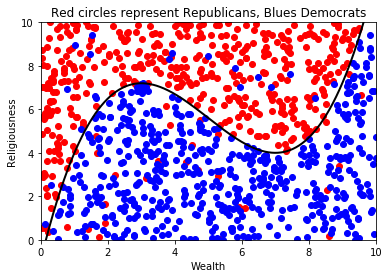

In [42]:
# Play this several times to see different sampling sets
X, y = generate_data(m=1000)
plot_labeled_data(X, y)

## Apply kNN Classifier

In [43]:
def predict_and_plot_boundary_knn(k, X_train, y_train, X):
    # k :number of neighbors
    # X_train and y_train: training datasets
    # X : data to predict
    
    h = .02  # step size in the mesh

    clf = KNeighborsClassifier(k)
    clf.fit(X_train, y_train)

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # predict for all points from the mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" %(k))

    plt.show()


## Analyse the properties of kNN

We generate multiple sample data sets of size 500 (use the given function above), and plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99, 150).

The decision plane should cover the range [0,10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors.

We will answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?
- Can we describe when do we underfit or overfit the data? 
- How does the complexity of this model depends on k?


In [7]:
X_train, y_train = generate_data(m=500, seed=5)

In [8]:
X, y = generate_data(m=500)

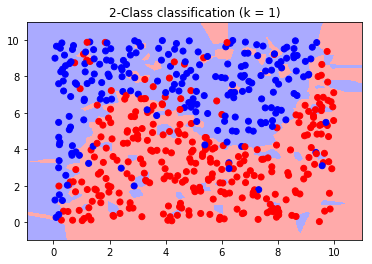

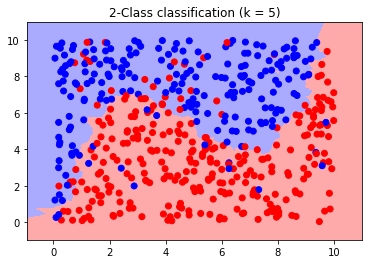

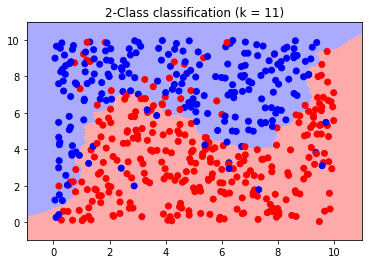

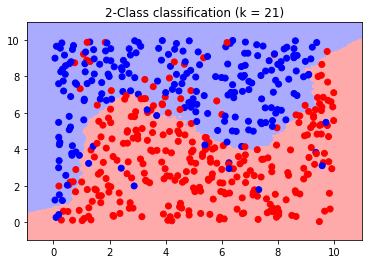

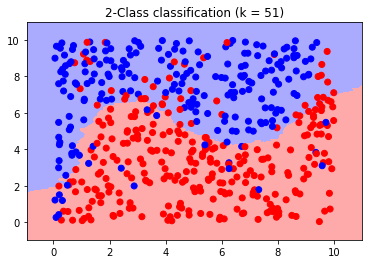

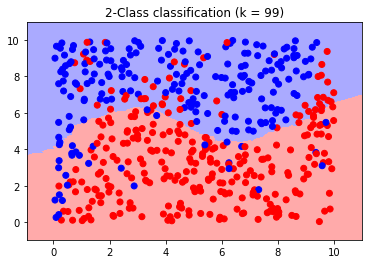

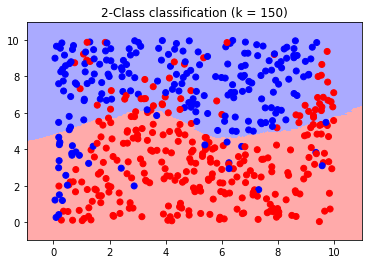

In [45]:
for k in [1, 5, 11, 21, 51, 99, 150]:
    predict_and_plot_boundary_knn(k, X_train, y_train, X)

1. More k is growing more the line separating the blue from red points is linear.

2. When k is high, we underfit the model because the algorithm takes far points from the new point to predict. However when k is too low we overfitting, espescially when k=1 we predict using the nearest point only. So if a supposed democrate point is added in the dataset in a region of republicain points the prediction wil be wrong.

3. The complexity of the algorithm of kNN method depends linearly on k.

## Finding the optimal k

We sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. Then we plot the train vs validation error for several k values, and choose the best k. 

Where do we underfit/overfit the data? Finally, we estimate the generalization error of our chosen classifier using the test set.


In [46]:
X, y = generate_data(m=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [57]:
#return errors function of k defined as 1-accuracy_score
def kNN_efficiency(k_list, X_for_fit, y_for_fit, X_for_pred, y_for_pred):
    errors_k = []
    for k in k_list:
        clf = kNNClassifier(k)
        clf.fit(X_for_fit, y_for_fit)
        y_pred = clf.predict(X_for_pred)
        err = 1 - accuracy_score(y_for_pred, y_pred)
        errors_k.append(err)
    return errors_k

In [62]:
k_list = [i for i in range(1,80,2)]

In [63]:
k_errors_train = kNN_efficiency(k_list, X_train, y_train, X_train, y_train)

In [64]:
k_errors_dev = kNN_efficiency(k_list, X_train, y_train, X_dev, y_dev)

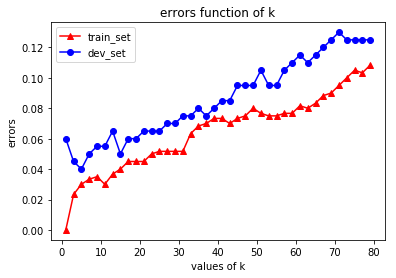

In [65]:
f = plt.figure()
plt.plot(k_list, k_errors_train, 'r', label='train_set', marker='^')
plt.plot( k_list, k_errors_dev, 'b', label='dev_set', marker='o')
plt.legend()
plt.title('errors function of k')
plt.xlabel('values of k')
plt.ylabel('errors')
plt.show()

The best value of k is 11 according to the errors plot of the dev set.

We can see that at the begining of the both curves there is a gap and after the errors seem to be stabilized and grow lineraly. A new gap appears when k = 55. We can suppose that, under 10 the model overfits and upper 55 the model overfits. So I suggest that the goog value of K is 17.

In [66]:
k_errors_test = kNN_efficiency(k_list, X_train, y_train, X_test, y_test)

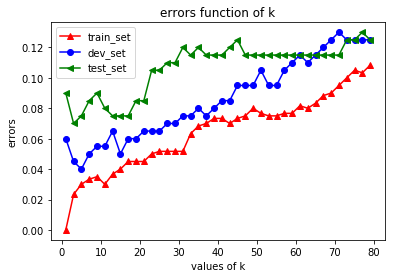

In [67]:
f = plt.figure()
plt.plot(k_list, k_errors_train, 'r', label='train_set', marker='^')
plt.plot( k_list, k_errors_dev, 'b', label='dev_set', marker='o')
plt.plot( k_list, k_errors_test, 'g', label='test_set', marker='<')
plt.legend()
plt.title('errors function of k')
plt.xlabel('values of k')
plt.ylabel('errors')
plt.show()

According to the errors plot and the supposed values of k and the number of elements in the sets, we can say that the best value of k would be k = 17.

## Using cross validation

This time, we put the test data aside (0.2 of the data), and we apply 5-fold CV on the remaining data to evaluate the performance of each k value. 

What is the size of the validation and train set now, in each CV iteration?
Did our final model selection change? We explain why.

In [99]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

kf = KFold(n_splits=5, random_state=42, shuffle=False)
k_list_scores = []
for k in k_list:
    k_scores_fold = []
    for train_index, dev_index in kf.split(X):
        X_kf_train, X_kf_dev = X[train_index], X[dev_index] 
        y_kf_train, y_kf_dev = y[train_index], y[dev_index]
        
        clf = kNNClassifier(k)
        clf.fit(X_kf_train, y_kf_train)
        y_pred_dev = clf.predict(X_kf_dev)
        err = 1 - accuracy_score(y_kf_dev, y_pred_dev)
        k_scores_fold.append(err)
  
    k_list_scores.append(np.mean(k_scores_fold))

/home/elbaz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


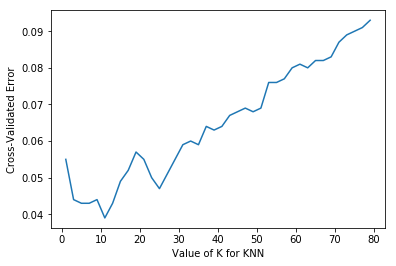

In [100]:
plt.plot(k_list, k_list_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Error')
plt.show()

We find that the optimal k is 27.

We run a KNN with k = 27 on the test set.

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf = kNNClassifier(27)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
err = 1 - accuracy_score(y_test, y_pred_test)
print('Error on the test set wit optimal k find by cross-valisation: ', err)

Error on the test set wit optimal k find by cross-valisation:  0.07999999999999996


The problem by splitting a dataset in a train, validation (dev), test sets is that we reduce the number of samples in datasets. The kNN model is highly dependent on the number of sample. So when we perform a fitting on the train set and apply it on the validation set, the parameters is no longer fitted for this set and cause under or over fitting. To avoid this issue, the k-cross permit to fit the parameters on several parts of the train set and apply an average on the result.
To sum up, the model trains in different part with same shape and return more suitable parameters.

# References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html